In [55]:
import os
import wget

In [56]:
CUSTOM_MODEL_NAME = 'my_ssd_mobilenet-new' 
PRETRAINED_MODEL_NAME = 'ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8'
PRETRAINED_MODEL_URL = 'http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8.tar.gz'
TF_RECORD_SCRIPT_NAME = 'generate_tfrecord.py'
LABEL_MAP_NAME = 'label_map.pbtxt'

In [57]:
paths = {
    'WORKSPACE_PATH': os.path.join('Tensorflow', 'workspace'),
    'SCRIPTS_PATH': os.path.join('Tensorflow','scripts'),
    'APIMODEL_PATH': os.path.join('Tensorflow','models'),
    'ANNOTATION_PATH': os.path.join('Tensorflow', 'workspace','annotations'),
    'IMAGE_PATH': os.path.join('Tensorflow', 'workspace','images'),
    'MODEL_PATH': os.path.join('Tensorflow', 'workspace','models'),
    'PRETRAINED_MODEL_PATH': os.path.join('Tensorflow', 'workspace','pre-trained-models'),
    'CHECKPOINT_PATH': os.path.join('Tensorflow', 'workspace','models',CUSTOM_MODEL_NAME), 
    'OUTPUT_PATH': os.path.join('Tensorflow', 'workspace','models',CUSTOM_MODEL_NAME, 'export'), 
    'TFJS_PATH':os.path.join('Tensorflow', 'workspace','models',CUSTOM_MODEL_NAME, 'tfjsexport'), 
    'TFLITE_PATH':os.path.join('Tensorflow', 'workspace','models',CUSTOM_MODEL_NAME, 'tfliteexport'), 
    'PROTOC_PATH':os.path.join('Tensorflow','protoc')
 }

ACTIONS_RECORD = os.path.join('Tensorflow', 'workspace', 'actions.txt')
language = 'hindi'

In [58]:
files = {
    'PIPELINE_CONFIG':os.path.join('Tensorflow', 'workspace','models', CUSTOM_MODEL_NAME, 'pipeline.config'),
    'TF_RECORD_SCRIPT': os.path.join(paths['SCRIPTS_PATH'], TF_RECORD_SCRIPT_NAME), 
    'LABELMAP': os.path.join(paths['ANNOTATION_PATH'], LABEL_MAP_NAME)
}

In [59]:
for path in paths.values():
    if not os.path.exists(path):
        if os.name == 'posix':
            !mkdir -p {path}
        if os.name == 'nt':
            !mkdir {path}

In [60]:
os.environ['PROTOCOL_BUFFERS_PYTHON_IMPLEMENTATION'] = 'python'

In [61]:
import tensorflow as tf
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.builders import model_builder
from object_detection.utils import config_util

In [62]:
# Load pipeline config and build a detection model
configs = config_util.get_configs_from_pipeline_file(files['PIPELINE_CONFIG'])
detection_model = model_builder.build(model_config=configs['model'], is_training=False)

# Restore checkpoint
ckpt = tf.compat.v2.train.Checkpoint(model=detection_model)
ckpt.restore(os.path.join(paths['CHECKPOINT_PATH'], 'ckpt-6')).expect_partial()

@tf.function
def detect_fn(image):
    image, shapes = detection_model.preprocess(image)
    prediction_dict = detection_model.predict(image, shapes)
    detections = detection_model.postprocess(prediction_dict, shapes)
    return detections

In [63]:
import cv2 
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

In [64]:
category_index = label_map_util.create_category_index_from_labelmap(files['LABELMAP'])

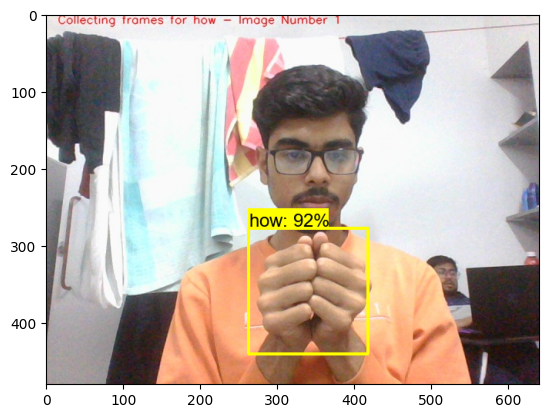

In [65]:
IMAGE_PATH = os.path.join(paths['IMAGE_PATH'], 'collectedimages', 'how.d7adff79-de2f-11ee-b404-6479f0d2f3ad.jpg')

img = cv2.imread(IMAGE_PATH)
image_np = np.array(img)

input_tensor = tf.convert_to_tensor(np.expand_dims(image_np, 0), dtype=tf.float32)
detections = detect_fn(input_tensor)

num_detections = int(detections.pop('num_detections'))
detections = {key: value[0, :num_detections].numpy()
              for key, value in detections.items()}
detections['num_detections'] = num_detections

# detection_classes should be ints.
detections['detection_classes'] = detections['detection_classes'].astype(np.int64)

label_id_offset = 1
image_np_with_detections = image_np.copy()

viz_utils.visualize_boxes_and_labels_on_image_array(
            image_np_with_detections,
            detections['detection_boxes'],
            detections['detection_classes']+label_id_offset,
            detections['detection_scores'],
            category_index,
            use_normalized_coordinates=True,
            max_boxes_to_draw=5,
            min_score_thresh=.8,
            agnostic_mode=False)

plt.imshow(cv2.cvtColor(image_np_with_detections, cv2.COLOR_BGR2RGB))
plt.show()

In [66]:
print(category_index[detections['detection_classes'][0]+label_id_offset]['name'])
print(detections['detection_boxes'][0])
print(detections['detection_scores'][0])

how
[0.57951176 0.40982822 0.9181795  0.65420806]
0.9196253


In [67]:
words = []

In [68]:
cap = cv2.VideoCapture(0)
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
prev_sign = ''
count = 0

while cap.isOpened(): 
    ret, frame = cap.read()
    image_np = np.array(frame)
    
    input_tensor = tf.convert_to_tensor(np.expand_dims(image_np, 0), dtype=tf.float32)
    detections = detect_fn(input_tensor)
    
    num_detections = int(detections.pop('num_detections'))
    detections = {key: value[0, :num_detections].numpy()
                  for key, value in detections.items()}
    detections['num_detections'] = num_detections

    # detection_classes should be ints.
    detections['detection_classes'] = detections['detection_classes'].astype(np.int64)

    label_id_offset = 1
    image_np_with_detections = image_np.copy()

    viz_utils.visualize_boxes_and_labels_on_image_array(
                image_np_with_detections,
                detections['detection_boxes'],
                detections['detection_classes']+label_id_offset,
                detections['detection_scores'],
                category_index,
                use_normalized_coordinates=True,
                max_boxes_to_draw=5,
                min_score_thresh=.7,
                agnostic_mode=False)
    

    sign = category_index[detections['detection_classes'][0]+label_id_offset]['name']
    accuracy = detections['detection_scores'][0]

    if(accuracy<0.7):
        sign = ''

    if(sign==prev_sign):
        count+=1
    else:
        prev_sign = sign
        count=1

    if(count==30 and sign!=''):
        words.append(sign)
        print(sign)

    cv2.imshow('object detection',  cv2.resize(image_np_with_detections, (800, 600)))
    
    if cv2.waitKey(10) & 0xFF == ord('q'):
        cap.release()
        cv2.destroyAllWindows()
        break

hello
how


Sentence Formation

In [15]:
print(words)

['hello', 'how', 'you']


In [21]:
import pprint
import google.generativeai as palm

# Configure the API key
palm.configure(api_key=<API_KEY>)

# List available models
models = [m for m in palm.list_models() if 'generateText' in m.supported_generation_methods]

# Select a model
model = models[0].name
print(model)

# Define prompt
words_test = ["hello", "how", "you"]
language = "english"
prompt = f"create sentence using the words {words_test} without adding extra words"

# Generate text
completion = palm.generate_text(
    model=model,
    prompt=prompt,
    temperature=0,
    max_output_tokens=800,
)
print(completion.result)


models/text-bison-001
Hello, how are you?


In [54]:
from translate import Translator

translator = Translator(provider='mymemory', from_lang='en', to_lang=language)
translation = translator.translate(completion.result)

print(f'{translation}')

हैलो, आप कैसे हैं?


In [3]:
from translate import Translator

sentence = 'Hello! How are you'

translator = Translator(provider='mymemory', from_lang='en', to_lang='fr')
translation = translator.translate(sentence)

print(f'{translation}')

Bonjour. Comment allez-vous
